In [35]:
import os
import importlib
import pandas as pd
import numpy as np
import torch
from IPython import embed
from tqdm import tqdm
import importlib
import umap
print('importing Tree.train')
import Tree.train as code
importlib.reload(code)
import glob
# set the seed
np.random.seed(0)
torch.manual_seed(0)

'''
way1: sum over the 4096 dimensions so that each chunk has only one embedding
way2: sum over the chunks so that each phage/host is a 4096-dim embedding
way3: avg over the chunks so that each phage/host is a 4096-dim embedding
'''
def process_dict_embed(embed_folder, embed_way='sum_chunk'):
    '''
    Given a folder of embeddings, <phage/bacteria_ID>.pt files, return a dictionary of embeddings
    key: <phage/bacteria_ID>,
    value: embedding tensor
    '''
    assert embed_way in ['sum_chunk', 'sum_dim', 'avg_phage'], 'embed_way should be one of sum_chunk, sum_dim, avg_phage'
    embed_dict = {}
    for embed_fn in glob.glob(f'{embed_folder}/*.pt'):
        embed_id = embed_fn.split('/')[-1].split('.pt')[0]
        if embed_way == 'sum_dim':
            embed_dict[embed_id] = torch.load(f'{embed_fn}').sum(dim=1,keepdim=True)  # sum over all the 4096 embed_dim so that each chunk has only one
        elif embed_way == 'sum_chunk':
            embed_dict[embed_id] = torch.load(f'{embed_fn}').sum(dim=0,keepdim=True) # sum over all the chunks so that each phage/host is a 4096-dim embedding
        elif embed_way == 'avg_phage':
            embed_dict[embed_id] = torch.load(f'{embed_fn}').mean(dim=0,keepdim=True) # avg over the chunks so that each phage/host is a 4096-dim embedding
        else:
            print('This should not happen')
            exit(1)
    return embed_dict


def pair_embed_sum_dim(phage_embed, host_embed, max_len):
    '''
    Concatenate phage_embed and host_embed with zeros in the middle to separate phage and host
    phage_embed and host_embed are tensors of shape (num_chunk, 1)
    '''
    total_len = phage_embed.shape[0] + host_embed.shape[0]
    if total_len < max_len:
        pad_len = max_len - total_len
        pair_embed = torch.cat((phage_embed, host_embed, torch.zeros(pad_len,1), ), dim=0)  # put zeros in the middle to separate phage and host
    else:
        print('This should not happen: pair_embed.shape[0] > max_len')
        pair_embed = torch.cat((phage_embed, host_embed), dim=0)
        pair_embed = pair_embed[:max_len]
    return pair_embed

def pair_embed_sum_chunk(phage_embed, host_embed):
    '''
    given phage_embed (4096, 1), host_embed (4096, 1), concatenate them into (8192, 1)
    '''
    pair_embed = torch.cat((phage_embed, host_embed), dim=1)
    pair_embed = pair_embed.view(-1, 1)
    return pair_embed

def prepare_training_data(phage_emb_dict, host_emb_dict, post_df, neg_df, max_len=175, embed_way='sum_chunk'):
    '''
    the training data includes:
    - embeddings: for each pair of phage, host, (phgee_embed, host_embed) concatenated
    - labels: 1 for positive pairs, 0 for negative pairs
    '''
    assert embed_way in ['sum_chunk', 'sum_dim', 'avg_phage'], 'embed_way should be one of sum_chunk, sum_dim, avg_phage'
    embeddings = []
    post_df['label'] = 1
    neg_df['label'] = 0
    comb_df = pd.concat([post_df, neg_df], axis=0)
    comb_df.reset_index(drop=True, inplace=True)
    for i in range(comb_df.shape[0]):
        phage_id = comb_df.iloc[i].Phage_ID
        host_id = comb_df.iloc[i].Host_ID
        phage_embed = phage_emb_dict[phage_id]
        host_embed = host_emb_dict[host_id]
        if embed_way == 'sum_dim':  # sum over all the 4096 embed_dim so that each chunk has only one number representation
            pair_embed = pair_embed_sum_dim(phage_embed, host_embed, max_len)  # shape: (max_len, 1)
        elif embed_way == 'sum_chunk':  # sum over all the chunks so that each phage/host is a 4096-dim embedding
            pair_embed = pair_embed_sum_chunk(phage_embed, host_embed)  # shape: (8192, 1)
        elif embed_way == 'avg_phage':  # avg over the chunks so that each phage/host is a 4096-dim embedding
            pair_embed = pair_embed_sum_chunk(phage_embed, host_embed) # shape: (8192, 1)
        else:
            print('This should not happen')
            exit(1)
        embeddings.append(pair_embed)
        # print(pair_embed.shape)
    labels = comb_df['label'].values
    embeddings = torch.stack(embeddings)  # shape: (num_pairs, max_len, 1)
    embeddings = embeddings.squeeze(-1)  # shape: (num_pairs, max_len)
    return embeddings, labels

importing Tree.train


In [42]:
negative_fold = 10
phage_embed = '/gladstone/engelhardt/lab/hvu/hackathonBio/vibiro/phage/embed/chunk_40K'
host_embed = '/gladstone/engelhardt/lab/hvu/hackathonBio/vibiro/hosts/embed/chunk_40K'
test_prompt_fn = '/gladstone/engelhardt/lab/hvu/hackathonBio/metadata/vibrio/train_positive_pairs.txt'
positive_fn = '/gladstone/engelhardt/lab/hvu/hackathonBio/metadata/vibrio/train_positive_pairs.txt'
embed_way = 'sum_chunk'
phage_embed_dict = process_dict_embed(phage_embed, embed_way=embed_way)
host_embed_dict = process_dict_embed(host_embed, embed_way=embed_way)
max_phage_len = max([x.shape[0] for x in phage_embed_dict.values()])
max_host_len = max([x.shape[0] for x in host_embed_dict.values()])
post_df = code.filter_only_present_pairs(positive_fn, phage_embed_dict, host_embed_dict)
neg_df = code.generate_negative_pairs(post_df, N = negative_fold*post_df.shape[0])
max_len = 175
embeddings, labels = prepare_training_data(phage_embed_dict, host_embed_dict, post_df, neg_df, max_len=max_len, embed_way=embed_way)
print(embeddings.shape, labels.shape)

Number of possible negative pairs: 49271
torch.Size([11330, 8192]) (11330,)


In [43]:
# now, for each pair of phage, host, we have the embeddings and labels. Each pair_embemd of shape (max_len, 1). 
# draw PCA plot to see if the embeddings are separable
def draw_umap(embeddings, labels, pc_ncomp=50, n_neighbors=50):
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    scaled_embed = StandardScaler().fit_transform(embeddings)
    pca = PCA(n_components=pc_ncomp, svd_solver='arpack')
    embeddings_pca=pca.fit_transform(scaled_embed)
    print(f'Finish information contraction using PCA')
    fumap=umap.UMAP(n_neighbors=n_neighbors)
    umap_embedding = fumap.fit_transform(embeddings_pca)
    plt.scatter(umap_embedding[labels==1,0],umap_embedding[labels==1,1],c='r',label='positive',alpha=0.1)
    plt.scatter(umap_embedding[labels==0,0],umap_embedding[labels==0,1],c='b',label='random',alpha=0.1)
    plt.title(f'{pc_ncomp} PCs \nneighbor{n_neighbors} UMAP ')
    plt.legend()
    plt.show()
    return umap_embedding



Finish information contraction using PCA


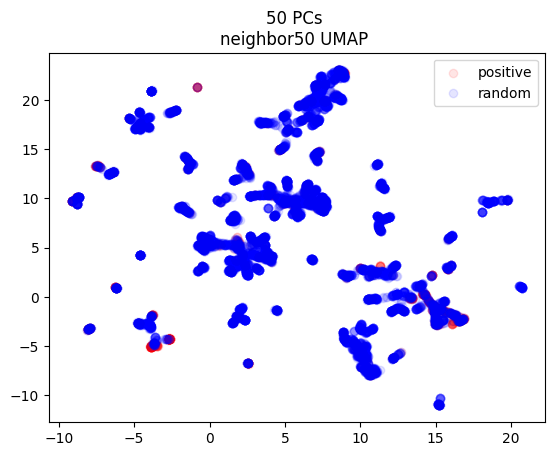

In [44]:
_ = draw_umap(embeddings, labels, pc_ncomp=50, n_neighbors=50)

In [45]:
def write_dummy_fasta(filename="dummy.fasta", sequence_length=5000):
    """
    Writes a dummy FASTA file containing a sequence of 'N's of specified length.

    Parameters:
    filename (str): Name of the output FASTA file.
    sequence_length (int): Length of the dummy sequence. Default is 5000.
    """
    with open(filename, "w") as fasta_file:
        # Write the FASTA header
        fasta_file.write(">dummy_sequence\n")
        
        # Write the sequence in lines of 80 characters for readability
        line_length = 80
        for i in range(0, sequence_length, line_length):
            fasta_file.write("N" * min(line_length, sequence_length - i) + "\n")

# Call the function to create the dummy FASTA file
write_dummy_fasta("dummy.fasta", sequence_length=5000)
